In [1]:
import matplotlib.pyplot as plt
import torch

from source import gridMA, PlaneSampler

# styling setting for plots
plt.style.use("classic")  # base style, no color themes
plt.rcParams.update({
    "font.family": "serif",          # use serif fonts (e.g. Times)
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "text.usetex": False,            # True if you want LaTeX fonts
    "axes.spines.top": False,
    "axes.spines.right": False,
})

## The Periodogram Teststatistic
We want to test a new kind of teststatistic which is motivated by the great results by Scaccia and Martin on testing axial symmetry of lattice processes.

The Idea behind this builds on the well established fact that:
$$
\frac{I(\vec\omega)}{f(\vec\omega)}\overset d\longrightarrow \text{Exp}(1) \quad n\to\infty
$$
With $I(\vec\omega)$ being asymptotically independent for high sample sizes. This means for very small grids we can get extremely fast convergence instead of using this property to permute.

Given periodogram $I_A$ and $I_B$, we want to compute:
$$
G_s^{A,B}(\vec\omega) = \frac{I_A(\vec\omega)-I_B(\vec\omega)}{I_A(\vec\omega) +I_B(\vec\omega)} \sim_{H_0}\mathcal U(-1,1)
$$

Then $|G_s|\sim_{H_0} \mathcal U(0,1)$ and consequently $E(|G_s|) = 0.5$ and $Var(|G_s|) = \frac 1{12}$. And we have $PT_3 :=\sqrt {12n}\,\overline{|G_s|}\overset d\longrightarrow \mathcal N(0,1)$.

Meaning we can use the quantiles from the standard normal as critical values for different $\alpha$.

In [4]:
import torch

# slop function for PT3
def periodogram_unshifted(x: torch.Tensor) -> torch.Tensor:
    n1, n2 = x.shape
    F = torch.fft.fft2(x)
    return (F.real**2 + F.imag**2) / (n1 * n2)

def quadrant_mask_unshifted(n1: int, n2: int, kmax1: int | None = None, kmax2: int | None = None,
                            stride1: int = 1, stride2: int = 1) -> torch.Tensor:
    """
    Keep only strict interior first quadrant (unshifted):
      k1 in {1,..., floor((n1-1)/2)} (or up to kmax1 if given)
      k2 in {1,..., floor((n2-1)/2)} (or up to kmax2 if given)
    Excludes 0 and Nyquist lines by construction. Optional strides to thin the grid.
    """
    max1 = (n1 - 1) // 2   # if n1 even, this is n1//2 - 1; if odd, (n1-1)//2
    max2 = (n2 - 1) // 2
    if kmax1 is not None:
        max1 = min(max1, int(kmax1))
    if kmax2 is not None:
        max2 = min(max2, int(kmax2))

    mask = torch.zeros((n1, n2), dtype=torch.bool)
    k1_vals = torch.arange(1, max1 + 1, step=max(1, stride1))
    k2_vals = torch.arange(1, max2 + 1, step=max(1, stride2))
    mask[k1_vals.unsqueeze(1), k2_vals.unsqueeze(0)] = True
    return mask

def PT3(x: torch.Tensor, y: torch.Tensor,
                                  kmax1: int | None = None, kmax2: int | None = None,
                                  stride1: int = 4, stride2: int = 4) -> torch.Tensor:
    """
    |R|-version of T3 on the unshifted grid, restricted to the strict interior first quadrant.
    Under H0 and independence, |R| ~ Unif(0,1) across selected freqs -> mean 0.5, var 1/12.
    """
    assert x.ndim == 2 and y.ndim == 2 and x.shape == y.shape
    n1, n2 = x.shape

    Ixu = periodogram_unshifted(x)
    Iyu = periodogram_unshifted(y)

    mask = quadrant_mask_unshifted(n1, n2, kmax1=kmax1, kmax2=kmax2, stride1=stride1, stride2=stride2)

    Ix = Ixu[mask]
    Iy = Iyu[mask]

    eps = torch.finfo(Ix.dtype).eps
    Rabs = torch.abs((Ix - Iy) / (Ix + Iy + eps))

    n_star = Rabs.numel()
    stat = torch.sqrt(torch.tensor(12.0, dtype=Rabs.dtype)) * torch.sqrt(torch.tensor(float(n_star), dtype=Rabs.dtype)) * (Rabs.mean() - 0.5)
    return stat


approximate size at alpha=0.05: 0.05460000038146973


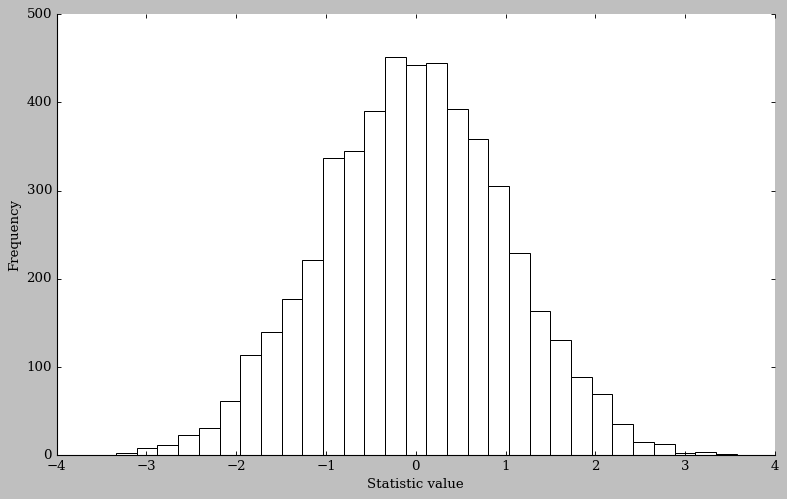

In [8]:
from scipy.stats import norm
# can it hold the size?
N = 5000
MxM = 7

ALPHA = .05
CRIT = norm.ppf(1 - ALPHA / 2)



K0 = torch.full((3,3), .7)
K0[1,1] = 1
K1 = torch.full((7,7), .5)

sampler0 = gridMA(K0)
sampler1 = gridMA(K1)


results = torch.zeros((N, 1))
for i in range(N):
    results[i] = PT3(sampler0(MxM, MxM)[0][0], sampler0(MxM, MxM)[0][0], stride1=1, stride2=1)

print(f"approximate size at alpha={ALPHA}: {(torch.abs(results) > CRIT).sum() / N}")

fig, ax = plt.subplots(figsize=(10, 6.4))
ax.hist(results, bins=30, color="white", edgecolor="black", linewidth=0.9)
ax.set_xlabel("Statistic value")
ax.set_ylabel("Frequency")
ax.grid(False)

# thin ticks and tight layout for print-ready figure
ax.tick_params(width=0.8, direction="in")
plt.tight_layout()
plt.show()

In [45]:
import torch

def mc_size_test(sampler_x, sampler_y, test, n1=100, n2=100, N=3000, alpha=0.05, device=None, dtype=torch.float64):
    device = device or torch.device("cpu")
    Normal01 = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=dtype),
                                          scale=torch.tensor(1., device=device, dtype=dtype))
    crit = Normal01.icdf(torch.tensor(1 - alpha/2, device=device, dtype=dtype))

    stats = torch.empty(N, device=device, dtype=dtype)

    with torch.no_grad():
        for i in range(N):
            # Two independent draws under H0 (same spectrum)
            x = sampler_x(n1, n2)[0][0].to(device=device, dtype=dtype)
            y = sampler_y(n1, n2)[0][0].to(device=device, dtype=dtype)
            stats[i] = test(x, y)  # assumes your corrected shift-aware T3

    # Estimated size (two-sided)
    rejections = (stats.abs() > crit).sum()
    size_hat = rejections.to(dtype=dtype) / torch.tensor(N, device=device, dtype=dtype)

    # Binomial standard error for context
    se = torch.sqrt(size_hat * (1 - size_hat) / N)

    # Optional sanity: mean≈0, sd≈1 under H0
    mean_stat = stats.mean()
    sd_stat = stats.std(unbiased=True)

    return {
        "alpha": alpha,
        "crit": crit.item(),
        "size_hat": size_hat.item(),
        "size_se": se.item(),
        "mean_stat": mean_stat.item(),
        "sd_stat": sd_stat.item(),
    }

mc_size_test(sampler0,sampler1, PT3, 20, 20)

{'alpha': 0.05,
 'crit': 1.959963984540054,
 'size_hat': 0.091,
 'size_se': 0.005250999904780041,
 'mean_stat': 0.6136465284871518,
 'sd_stat': 0.9996203223773005}

## Powersimulations

In [65]:
# we are going to abstract away most of the simulation code, such that we can focus on the alternative
def power_sim(sampler0, h1_generator, deltas, N = 200, grid_sizes = [20, 25, 30, 40, 50]):
    rejected = torch.zeros(5, 20)
    i = 0
    for grid_size in grid_sizes:
        PT3_MC = torch.vmap(lambda x, y: PT3(x, y),
                                    randomness="different")
        j = 0
        for delta in deltas:
            sampler1 = h1_generator(delta)
            x = sampler1(grid_size, grid_size, N)
            y = sampler0(grid_size, grid_size, N)
            results = PT3_MC(x[:, 0], y[:, 0])
            rejected[i, j] = (torch.abs(results)/1.5 > CRIT).sum() / N
            j += 1
        i += 1
    return rejected, results

def plot_power_result(rejected, deltas, grid_sizes = [20, 25, 30, 40, 50], N=200):
  # reset matplotlib style to defaults
  plt.rcdefaults()

  fig, ax = plt.subplots(dpi=150)
  for i in range(rejected.shape[0]):
      ax.plot(deltas, rejected[i], label=f"{grid_sizes[i]} × {grid_sizes[i]}")
  
  ax.set_title(f"Power for N = {N}")
  ax.set_xlabel(r"$\delta$")
  ax.set_ylabel("Approximate Power")
  ax.legend(title="Grid size", loc="upper left", frameon=True)
  
  plt.tight_layout()
  plt.show()

In [66]:
K0 = torch.full((3,3),.7)
K0[1,1] = 1

sampler0 = gridMA(K0)

def blur_h1_gen(delta):
  K1 = torch.full((7,7), delta)
  K1[3:6, 3:6] = K0
  return gridMA(K1)

deltas = torch.linspace(0, .7, 20)

rej_h1_ma_full, results = power_sim(sampler0, blur_h1_gen, deltas, 5000)

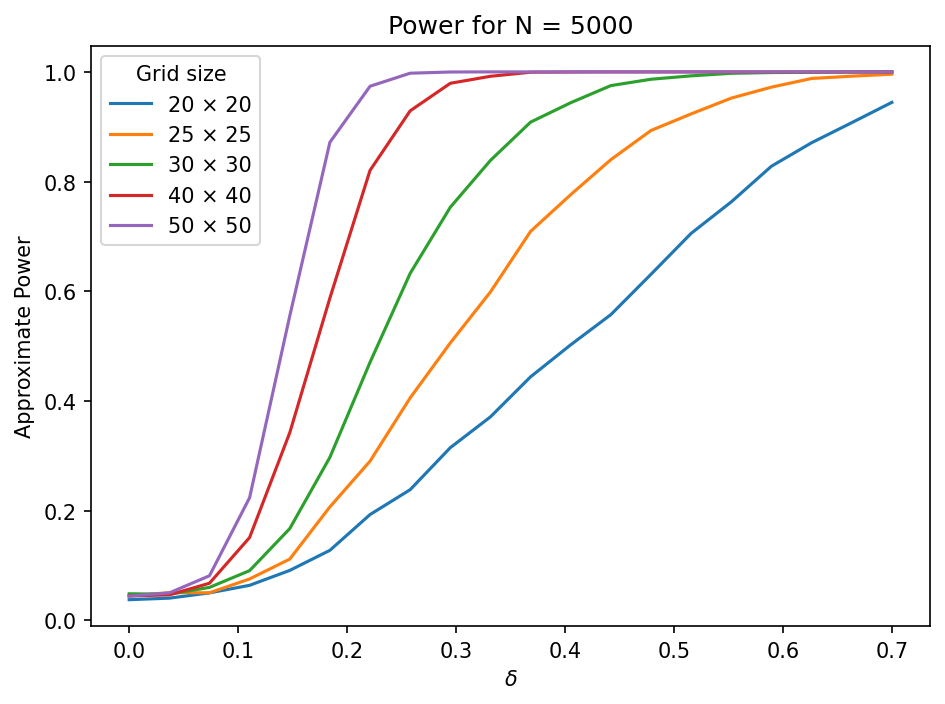

In [67]:
plot_power_result(rej_h1_ma_full, deltas, N=5000)

In [68]:
def spin_gen(delta, diag = .03):
  sampler = PlaneSampler(40, .1 + delta, diag, 0.8-delta)
  return sampler

sampler_AR0 = spin_gen(0.0)

rej_h1_AR_spin = power_sim(sampler_AR0, spin_gen, deltas)

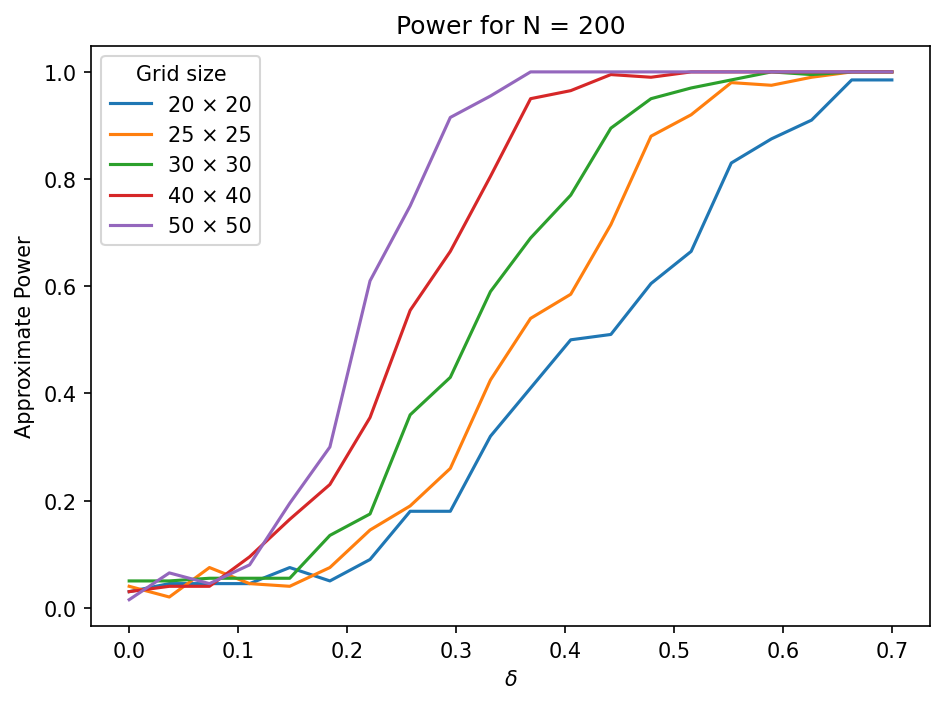

In [69]:
plot_power_result(rej_h1_AR_spin[0], deltas)